# Project - Big Data and Cloud Computing

### Importing Libraries and Data Ingestion

In [23]:
import time
import json
from numpy import array, mean
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.sql.functions import to_timestamp, to_date, month, lit, datediff, col, dayofweek, year
from pyspark.sql.functions import from_json, col, udf, schema_of_json, size, explode, collect_set, map_keys
from pyspark.sql.functions import isnan, when, count, col, lower, split, trim, concat_ws, rank
from pyspark.sql.functions import col, sum, avg, min, countDistinct

from datetime import datetime, timedelta

from pyspark.sql.types import BooleanType, MapType, StructType, StructField, StringType, TimestampType, IntegerType, LongType, FloatType, DoubleType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# creates Spark session
spark = SparkSession.builder.appName('Stack Overflow').getOrCreate()

# change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

# set log level
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d4477179-8a3b-4fb4-af54-a0a0a974cd3f;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

### Data

In [3]:
sof_data = spark.read.parquet("gs://msca-bdp-student-gcs/Group6/StackOverflow_test.parquet", inferSchema=True, header=True)

In [4]:
sof_data.describe().show()

24/11/16 17:56:52 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+--------------------+-----------------------+-----------------+------------------+-------------------------+--------------------+-------------------+-----------------------+--------------------+-----------------------------+------------------------+-----------------------+------------------+--------------+-----------------+------------------+--------------------+------------------+--------------------+------------+--------------------+-------------------------+-------------------+--------------------+---------------------------+--------------------+---------------------+-------------------------+---------------------+-------------------------------+--------------------------+-------------------------+--------------------+-------------------+-------------------+------------------+-----------+-----------------+
|summary|             post_id|          post_title|           post_body|post_accepted_answer_id|post_answer_count|post_comment_c

In [5]:
sof_data.printSchema()

root
 |-- post_id: long (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_body: string (nullable = true)
 |-- post_accepted_answer_id: long (nullable = true)
 |-- post_answer_count: long (nullable = true)
 |-- post_comment_count: long (nullable = true)
 |-- post_community_owned_date: long (nullable = true)
 |-- post_creation_date: long (nullable = true)
 |-- post_favorite_count: long (nullable = true)
 |-- post_last_activity_date: long (nullable = true)
 |-- post_last_edit_date: long (nullable = true)
 |-- post_last_editor_display_name: string (nullable = true)
 |-- post_last_editor_user_id: long (nullable = true)
 |-- post_owner_display_name: string (nullable = true)
 |-- post_owner_user_id: long (nullable = true)
 |-- post_parent_id: long (nullable = true)
 |-- post_post_type_id: long (nullable = true)
 |-- post_score: long (nullable = true)
 |-- post_tags: string (nullable = true)
 |-- post_view_count: long (nullable = true)
 |-- answer_id: long (nullable = true)

In [6]:
def displaypartitions(sof_data):
    num = sof_data.rdd.getNumPartitions()
    print("Partitions:", num)
    sof_data.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)
    
displaypartitions(sof_data)

Partitions: 6


+-----------+------+
|partitionId| count|
+-----------+------+
|          2|796200|
+-----------+------+



In [7]:
sof_data = sof_data.repartition(6)
displaypartitions(sof_data)

Partitions: 6


+-----------+------+
|partitionId| count|
+-----------+------+
|          1|132700|
|          5|132700|
|          0|132700|
|          3|132700|
|          4|132700|
|          2|132700|
+-----------+------+



### EDA

In [8]:
total_rows = sof_data.count()
print(f"Total rows: {total_rows}")

total_unique_rows = sof_data.select("post_id").distinct().count()
print(f"Total unique post_ids (questions): {total_unique_rows}")

Total rows: 796200


Total unique post_ids (questions): 123576


In [9]:
null_counts = sof_data.select([sum(col(column).isNull().cast("int")).alias(column) for column in sof_data.columns])
null_counts.show()

+-------+----------+---------+-----------------------+-----------------+------------------+-------------------------+------------------+-------------------+-----------------------+-------------------+-----------------------------+------------------------+-----------------------+------------------+--------------+-----------------+----------+---------+---------------+---------+------------+-----------+-------------------------+-------------------+--------------------+---------------------------+--------------------+---------------------+-------------------------+---------------------+-------------------------------+--------------------------+-------------------------+--------------------+----------------+-------------------+------------+-----------+-----------------+
|post_id|post_title|post_body|post_accepted_answer_id|post_answer_count|post_comment_count|post_community_owned_date|post_creation_date|post_favorite_count|post_last_activity_date|post_last_edit_date|post_last_editor_display

In [10]:
columns_to_drop = [
    "post_community_owned_date", "post_last_editor_display_name", 
    "post_owner_display_name", "post_parent_id", "answer_title", 
    "answer_accepted_answer_id", "answer_answer_count", 
    "answer_community_owned_date", "answer_favorite_count", 
    "answer_last_editor_display_name", "answer_owner_display_name", 
    "answer_tags", "answer_view_count"
]

sof_data = sof_data.drop(*columns_to_drop)

In [11]:
sof_data = sof_data.withColumn("post_creation_date", F.to_date(F.from_unixtime(F.col("post_creation_date") / 1e9))) \
       .withColumn("post_last_activity_date", F.to_date(F.from_unixtime(F.col("post_last_activity_date") / 1e9))) \
       .withColumn("post_last_edit_date", F.to_date(F.from_unixtime(F.col("post_last_edit_date") / 1e9))) \
       .withColumn("answer_last_activity_date", F.to_date(F.from_unixtime(F.col("answer_last_activity_date") / 1e9))) \
       .withColumn("answer_last_edit_date", F.to_date(F.from_unixtime(F.col("answer_last_edit_date") / 1e9)))

sof_data.printSchema()

root
 |-- post_id: long (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_body: string (nullable = true)
 |-- post_accepted_answer_id: long (nullable = true)
 |-- post_answer_count: long (nullable = true)
 |-- post_comment_count: long (nullable = true)
 |-- post_creation_date: date (nullable = true)
 |-- post_favorite_count: long (nullable = true)
 |-- post_last_activity_date: date (nullable = true)
 |-- post_last_edit_date: date (nullable = true)
 |-- post_last_editor_user_id: long (nullable = true)
 |-- post_owner_user_id: long (nullable = true)
 |-- post_post_type_id: long (nullable = true)
 |-- post_score: long (nullable = true)
 |-- post_tags: string (nullable = true)
 |-- post_view_count: long (nullable = true)
 |-- answer_id: long (nullable = true)
 |-- answer_body: string (nullable = true)
 |-- answer_comment_count: long (nullable = true)
 |-- answer_creation_date: long (nullable = true)
 |-- answer_last_activity_date: date (nullable = true)
 |-- answer_last

Columns that have close to 0 values: post_community_owned_date, post_last_editor_display_name, post_owner_display_name, post_parent_id, answer_title, answer_accepted_answer_id, answer_answer_count, answer_community_owned_date, answer_favorite_count, answer_last_editor_display_name, answer_owner_display_name, answer_tags, answer_view_count.

In [12]:
# Percentage of posts that have tags
unique_tagged_posts_count = sof_data.filter(F.col("post_tags").isNotNull()).select("post_id").distinct().count()
percentage_tagged_posts = (unique_tagged_posts_count / total_unique_rows) * 100
print(f"Percentage of posts with tags: {percentage_tagged_posts:.2f}%")

Percentage of posts with tags: 100.00%


In [14]:
# Count of posts with verified answers
verified_answers_count = sof_data.filter(F.col("post_accepted_answer_id").isNotNull()).count()
percentage_verified_answers = (verified_answers_count / total_rows) * 100
print(f"Posts with accepted answers: {percentage_verified_answers:.2f}%")

Posts with accepted answers: 70.22%


In [15]:
# Number of answers per post
sof_data.groupBy("post_id").agg(F.count("answer_id").alias("Answer Count")).orderBy(F.desc("Answer Count")).show(10)

+--------+------------+
| post_id|Answer Count|
+--------+------------+
|17054000|          98|
|20915266|          90|
|22876978|          79|
|29500227|          78|
|18880341|          76|
|18022809|          75|
|15825081|          75|
|16596877|          73|
|15738259|          68|
|18102859|          68|
+--------+------------+
only showing top 10 rows



In [16]:
# Average post text size in characters
sof_data1 = sof_data.withColumn("post_text_size", F.length(F.col("post_body"))) \
       .withColumn("answer_text_size", F.length(F.col("answer_body")))

# Average answer text size in characters
sof_data1.select(F.avg("post_text_size").alias("Average Post Text Size"),
          F.avg("answer_text_size").alias("Average Answer Text Size")).show()

+----------------------+------------------------+
|Average Post Text Size|Average Answer Text Size|
+----------------------+------------------------+
|     1110.858219040442|       725.1361697634339|
+----------------------+------------------------+



In [17]:
# Correlation of text size with answer count
text_size_answer_correlation = sof_data1.stat.corr("post_text_size", "post_answer_count")
print(f"Correlation between post text size and answer count: {text_size_answer_correlation:.2f}")

Correlation between post text size and answer count: 0.02


In [18]:
# Correlation of post score with answer count
score_answer_correlation = sof_data1.stat.corr("post_score", "post_answer_count")
print(f"Correlation between post score and answer count: {score_answer_correlation:.2f}")

Correlation between post score and answer count: 0.44


In [19]:
sof_data1 = sof_data.withColumn("post_year_month", F.date_format("post_creation_date", "yyyy-MM"))
sof_data1 = sof_data.withColumn("post_year", F.date_format("post_creation_date", "yyyy"))

In [20]:
# questions per year

questions_by_year = sof_data1.groupBy("post_year").agg(
    F.count("post_creation_date").alias("Number of Questions"),
)

questions_by_year.orderBy("post_year").show()

+---------+-------------------+
|post_year|Number of Questions|
+---------+-------------------+
|     2013|             373271|
|     2014|             221735|
|     2015|             147188|
|     2016|              54006|
+---------+-------------------+



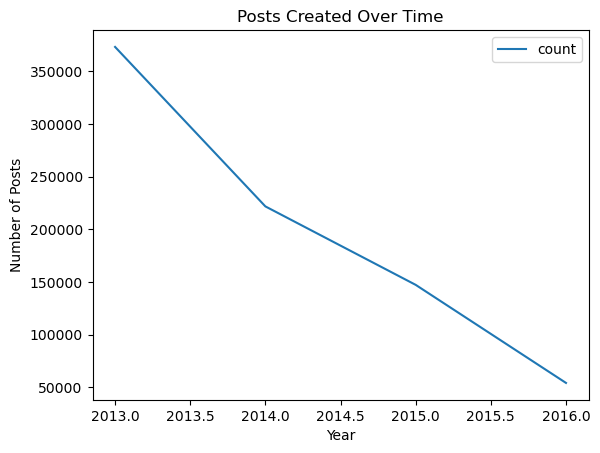

In [42]:
from pyspark.sql.functions import year

posts_per_year = (
    sof_data.groupBy(year("post_creation_date").alias("year"))
    .count()
    .orderBy("year")
)

posts_per_year_pd = posts_per_year.toPandas()

posts_per_year_pd.plot(kind="line", x="year", y="count", title="Posts Created Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.show()

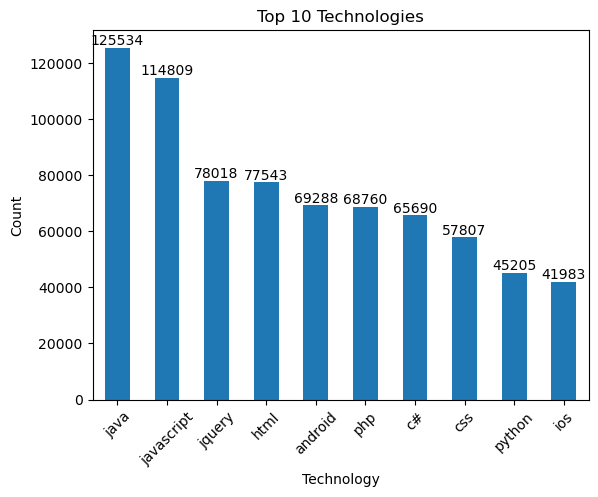

In [26]:
# top 10 technologies
from pyspark.sql import functions as F

unique_tagged_posts_count = (sof_data
              .withColumn('technology_name', F.split('post_tags', '\|'))
              .withColumn('technology_name', F.explode('technology_name'))
              .groupBy('technology_name')
              .count()
              .withColumnRenamed('count', 'count')
              .orderBy(F.col('count').desc())
              .limit(10)
)

top_10_tags_pd = unique_tagged_posts_count.toPandas()

ax = top_10_tags_pd.plot(kind='bar', x='technology_name', y='count', title='Top 10 Technologies', xlabel='Technology', ylabel='Count', legend=False)

for i in range(len(top_10_tags_pd)):
    ax.text(i, top_10_tags_pd['count'].iloc[i] + 0.05, str(top_10_tags_pd['count'].iloc[i]), ha='center', va='bottom')

plt.xticks(rotation=45)

plt.show()